# Lekce 13: Metody hledání volných lokálních extrémů

Nejdříve načtěme nutné balíčky.

In [1]:
using LinearAlgebra
using Plots

include("utilities.jl");

# Visualizace gradientu

V tomto příkladě budeme uvažovat funkci $f(x_1,x_2) = \sin(x_1+x_2) + \cos^2(x_1)$. Zadefinujme ji jako `f` a spočtěme její derivaci v `g`. Opakujme stejný trik s možností volání `f` s dvěma skaláry či jedním vektorem.

In [2]:
f(x) = sin(x[1] + x[2]) + cos(x[1])^2
g(x) = [cos(x[1] + x[2]) - 2*cos(x[1])*sin(x[1]); cos(x[1] + x[2])]
f(x1,x2) = f([x1;x2])
g(x1,x2) = g([x1;x2]);

Zadefinujme definiční obor $[-3,2]\times [-2,2]$.

In [3]:
xlim = (-3, 2)
ylim = (-2, 2);

Opět vykresleme vrstevnice funkce `f`.

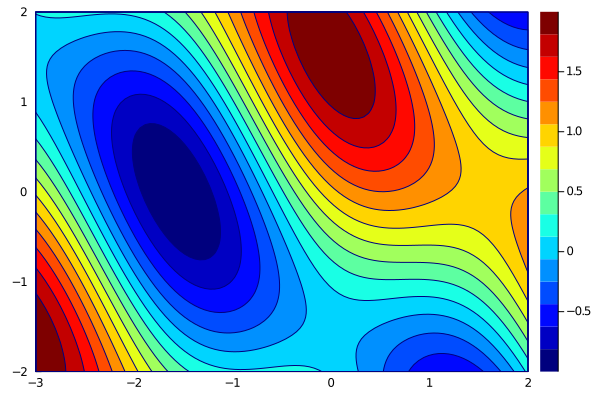

In [4]:
xs = range(xlim[1], xlim[2], length = 100)
ys = range(ylim[1], ylim[2], length = 100)
plt = contourf(xs, ys, f; color = :jet, xlim=xlim, ylim=ylim)

Nyní ve vybraných bodech vykreslíme gradient. Aby těchto bodů nebylo moc, uděláme diskretizaci domény délky 20. Poté spustíme for cyklus, kde v každém bodě `x` spočteme jeho gradient `x_grad` a vykreslíme šipku z `x` do `x+α*x_grad`.

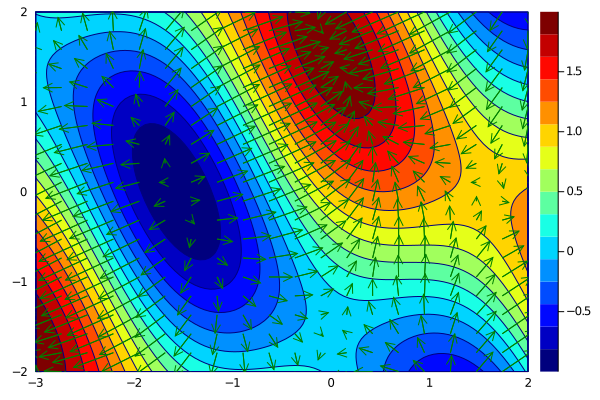

In [5]:
xs = range(xlim[1], xlim[2], length = 20)
ys = range(ylim[1], ylim[2], length = 20)

α = 0.25
for x1 in xs, x2 in ys
    x = [x1; x2]
    x_grad = [x x.+α.*g(x)]

    plot!(x_grad[1, :], x_grad[2, :];
        line = (:arrow, 1, :green),
        label = "",
    )
end
display(plt)

Protože tento graf přiřazuje vektorům vektory, jmenuje se vektorové pole. Je dobré si povšimnout několika věcí:
- Gradienty jsou kolmé na vrstevnice. To odpovídá tomu, že vrstevnice jsou množiny bodů se stejnou funkční hodnotou a gradient je směr největšího růstu.
- Gradient je malý v bodech lokálních minim a maxim. To je ale přesně Fermatova věta.

# Gradient descent

Nejprve zadefinujme zakladni variantu metody největšího spádu (gradient descent). V každém kroku uděláme update `x -= α*grad(x)`, což je ekvivalentní `x = x - α*grad(x)`. Iterace přerušíme, pokud norma gradientu je menší než `ϵ_tol`. Pokud se neuvedou jiné hodnoty, použije funkce `grad_descent` defaultní hodnoty $\alpha=0.1$, 100 iterací a zastavovací podmínku na $10^{-6}$.

In [6]:
function grad_descent(grad, x; α=1e-1, max_iter=100, ϵ_tol=1e-6)
    for i in 1:max_iter
        x -= α*grad(x)
        if norm(grad(x)) <= ϵ_tol
            break
        end
    end
    return x
end;

Vidíme, že implementace je jednoduchá. Předchozí funkce vrací pouze poslední hodnotu, což je v mnoha případech postačující. Pro vykreslení je ale dobré mít všechny iterace. Předefinujeme tedy funkci `grad_descent` tak, aby vracela i všechny iterace a rezidua (normy gradientu).

In [7]:
function grad_descent(grad, x; α=1e-1, max_iter=100, ϵ_tol=1e-6)
    res = zeros(max_iter)
    x_all = zeros(length(x), max_iter)
    for i in 1:max_iter
        x_all[:,i] .= x
        x -= α*grad(x)
        res[i] = norm(grad(x))
        if norm(grad(x)) <= ϵ_tol
            res = res[1:i]
            x_all = x_all[:,1:i]
            break
        end
    end
    return x, x_all, res
end;

Vykresleme nyní, jak gradient descent funguje. Začněme z bodu $x_0=(0; -1)$ a použijme funkci `grad_descent` k uložení všech iterací do `x_all` a všech reziduí do `res`. Vytvořme animaci, jak se vyvijí jednotlivé iterace.

In [8]:
x0 = [0.; -1]
x, x_all, res = grad_descent(g, x0)
create_anim("Anim_GD1.gif", f, x_all, xlim, ylim);

![](Anim_GD1.gif)

Dostali jsme pěknou konvergenci. Vypadá to ale, že v posledních iterací se proměnná skoro nehýbe. Zvětšeme počet iterací na 1000, proveďme gradient descent ze stejného bodu a vykresleme vývoj reziduí. Použijme logaritmickou $y$ osu.

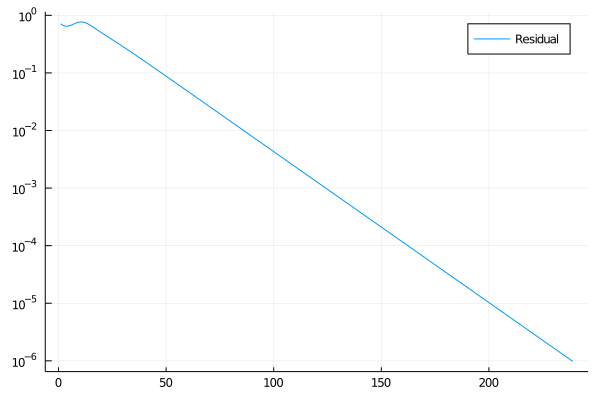

In [9]:
x1, x_all1, res1 = grad_descent(g, x0; max_iter=1000)
plot(res1; yscale=:log10, label="Residual")

Vidíme, že rezidua jdou k nule, a tedy konvergujeme ke stacionárnímu bodu. Na předepsanou toleranci $10^{-6}$ se dostaneme ale přibližně až za 250 iterací.

Zkousme vykreslit, co se stane, když zvolíme krok $\alpha$ postupně $0.01$, $1$ a $10$.

In [10]:
x2, x_all2, res2 = grad_descent(g, x0; α=1e-2)
create_anim("Anim_GD2.gif", f, x_all2, xlim, ylim)

x3, x_all3, res3 = grad_descent(g, x0; α=1e0)
create_anim("Anim_GD3.gif", f, x_all3, xlim, ylim)

x4, x_all4, res4 = grad_descent(g, x0; α=1e1)
create_anim("Anim_GD4.gif", f, x_all4, xlim, ylim);

![](Anim_GD2.gif)

![](Anim_GD3.gif)

![](Anim_GD4.gif)

Pří malém kroku sice konvergujeme, ale rychlost je pomalá. Při větším kroku se rychle dostaneme poblíž minima, ale poté začneme oscilovat. Při největších kroku divergujeme.

# Volba kroku pomocí Armijo podmínky

Předchozí cvičení ukazuje, že volba délky kroku je trochu magie a špatné volba může vést k pomalé konvergenci nebo dokonce divergenci. Z tohoto důvodu se používají automatické volby kroku. Na přednášce jsme si ukazovali Armijo podmínku. Při její implementaci začneme s `α = α0` a poté zmenšujeme `α`, dokud není podmínka splněna. Teoretické výsledky ukazují, že nějaké takové `α` bude vždy existovat.

In [11]:
function armijo(grad, x; α=1e-1, max_iter=100, ϵ_tol=1e-6, α0=1, c=1e-4)
    for i in 1:max_iter
        α = α0
        while f(x - α*grad(x)) > f(x) - c*α*norm(grad(x))^2
            α /= 2
        end
        x -= α*grad(x)
        if norm(grad(x)) <= ϵ_tol
            break
        end
    end
    return x
end;

Podobně jako u gradient descentu, uděláme i verzi, která vrací iterace a rezidua.

In [12]:
function armijo(grad, x; α=1e-1, max_iter=100, ϵ_tol=1e-6, α0=1, c=1e-4)
    res = zeros(max_iter)
    x_all = zeros(length(x), max_iter)
    for i in 1:max_iter
        α = α0
        while f(x - α*grad(x)) > f(x) - c*α*norm(grad(x))^2
            α /= 2
            if α <= 1e-8
                error("Armijo search failed")
            end
        end
        x_all[:,i] .= x
        x -= α*grad(x)
        res[i] = norm(grad(x))
        if norm(grad(x)) <= ϵ_tol
            res = res[1:i]
            x_all = x_all[:,1:i]
            break
        end
    end
    return x, x_all, res
end;

Pusťme nyní optimalizaci s volbu kroku podle Armijo podmínky.

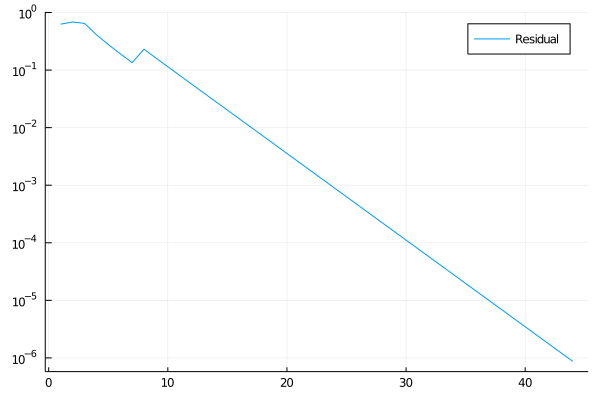

In [13]:
x5, x_all5, res5 = armijo(g, x0)
plot(res5; yscale=:log10, label="Residual")

Konvergence je rychlá. K tomu, abychom se dostali na stejný reziduál nyní potřebujeme jenom 45 iterací.

In [14]:
create_anim("Anim_GD5.gif", f, x_all5, xlim, ylim)

![](Anim_GD5.gif)

# Babylónská metoda

Babylónská metoda počítá $\sqrt{a}$. Jde odvodit, že se jedná o aplikaci Newtonovy metody na rovnici $x^2-a=0$.

In [15]:
a = 5
max_iter = 10
babs = zeros(max_iter)
babs[1] = a
for i in 1:max_iter-1
    babs[i+1] = 0.5(babs[i] + a/babs[i])
end;

Když vykreslíme rezidua, vidíme, že jdou k nule extrémně rychle. Musíme vybrat pouze kladná rezidua, protože je kleslíme v logaritmické škále.

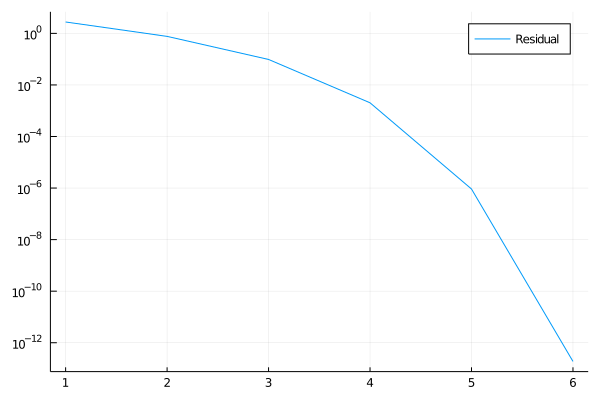

In [16]:
res = abs.(babs .- sqrt(a))
res = res[res .> 0]

plot(res; yscale=:log10, label="Residual")

# Newtonova metoda

Pro Newtonovu metodu opět definujeme nejdříve její základní variantu.

In [17]:
function newton(grad, hess, x; max_iter=100, ϵ_tol=1e-12)
    for i in 1:max_iter
        x -= hess(x) \ grad(x)
        if norm(grad(x)) <= ϵ_tol
            break
        end
    end
    return x
end;

A poté ji přepíšeme variantou, která vrací  vsechny iterace a residua.

In [18]:
function newton(grad, hess, x; max_iter=100, ϵ_tol=1e-12)
    res = zeros(max_iter)
    x_all = zeros(length(x), max_iter)
    for i in 1:max_iter
        x_all[:,i] .= x
        x -= hess(x) \ grad(x)
        res[i] = norm(grad(x))
        if norm(grad(x)) <= ϵ_tol
            res = res[1:i]
            x_all = x_all[:,1:i]
            break
        end
    end
    return x, x_all, res
end;

Protože člověk je tvor líný, a nechce se nám znova a znova počítat všechny derivace. Použijeme balík `Zygote`, který za nás derivaci i Hessián spočte.

In [19]:
using Zygote
using Zygote: hessian

f(x) = sin(x[1] + x[2]) + cos(x[1])^2
g(x) = gradient(f, x)[1]
h(x) = hessian(f, x);

Nyní můžeme pustit Newtonovu metody.

In [20]:
x, x_all, res = newton(g, h, x0);

Vidíme konvergenci ve třech iteracích.

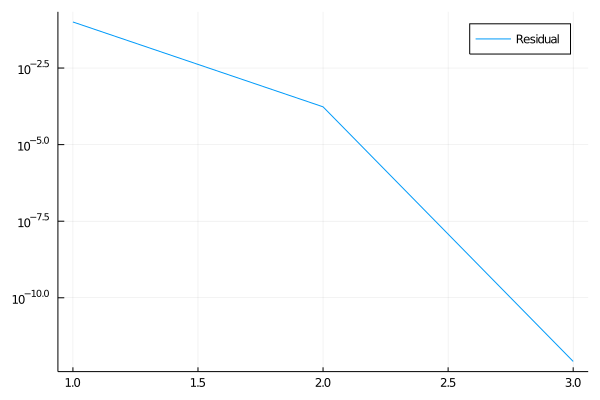

In [21]:
plot(res; yscale=:log10, label="Residual")

Když ale vykreslíme konvergenci, vidíme, že Newtonova metoda konverguje k sedlovému bodu.

In [22]:
create_anim("Anim_Newton1.gif", f, x_all, xlim, ylim)

![](Anim_Newton1.gif)

I když je derivace nulová.

In [23]:
g(x)

2-element Array{Float64,1}:
 -5.912435776804551e-13
 -5.91243550575401e-13

Hessián je indefinitní, jak vidíme z jeho jednoho pozitiního a jednoho negativního vlastního čísla.

In [24]:
eigvals(h(x))

2-element Array{Float64,1}:
 -1.4142135623730951
  1.4142135623730951

Toto tedy není bod, ke kterému bychom chtěli konvergovat. Zkusme start z jiného bodu.

In [25]:
x, x_all, res = newton(g, h, [-0.5; 0.5])

LoadError: [91mDomainError with -Inf:[39m
[91msincos(x) is only defined for finite x.[39m

Dostali jsme chybu, jejíž první řádek říká, že někde v kódu je $\infty$. Matice Hessiánu vypadá podezřele.

In [26]:
h([-0.5; 0.5])

2×2 Array{Float64,2}:
 -1.0806  0.0
  0.0     0.0

Její hodnost v první iteraci je 1. V Newtonově metodě tuto matici musíme invertovat. Její inverze ale neexistuje. To je důvod, proč Newtonova metoda selhala.

In [27]:
rank(h([-0.5; 0.5]))

1

Když pustíme Newtonovu metodu z jiného bodu, vidíme opět extrémně rychlou kovergenci reziduí.

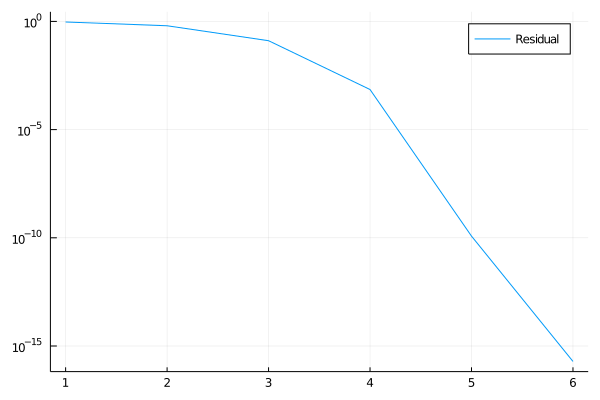

In [28]:
x, x_all, res = newton(g, h, [-1; 0])
plot(res; yscale=:log10, label="Residual")

Tentokrát to vypadá, že jsme dokonvergovali ke správnému bodu.

In [29]:
create_anim("Anim_Newton2.gif", f, x_all, xlim, ylim)

![](Anim_Newton2.gif)

Derivace je nulová.

In [30]:
g(x)

2-element Array{Float64,1}:
 1.8369701987210297e-16
 6.123233995736766e-17

A Hessián je pozitivně definitní. Jsme konečně v lokálním minimu,

In [31]:
eigvals(h(x))

2-element Array{Float64,1}:
 0.5857864376269051
 3.414213562373095

Závěrem řekneme, že Newton je velmi rychlá metoda. Pokud konverguje. I pro Newtonovu metodu se někdy používá zkrácený krok. Toto ale nevyšení problémy s divergencí, když Hessián nemá plnou hodnost.

# Porovnání metod

Uvažujme funkci $f(x) = e^{-x^2} - \frac12e^{-(x-1)^2} - \frac12e^{-(x+1)^2}$. Zadefinujme ji a opět využijme automatickou diferenciaci pro výpočet první a druhé derivace.

In [32]:
f(x) = exp(-x^2) - 0.5*exp(-(x-1)^2) - 0.5*exp(-(x+1)^2)
g(x) = gradient(f, x)[1]
h(x) = hessian(x -> f(x[1]), [x])[1];

Vykresleme tuto funkci a její první dvě derivace.

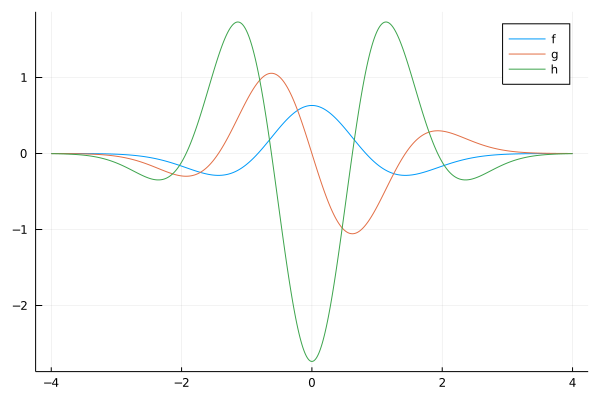

In [33]:
xs = -4:0.01:4
plot(xs, [f; g; h], label=["f" "g" "h"])

Nyní tuto funkce zoptimalizujme z počátečního bodu $x_0=1$ pomocí gradient descentu a Newtonovy metody.

In [34]:
x0 = 1
x1, x_all1 = grad_descent(g, x0)
x2, x_all2 = newton(g, h, x0);

Dále zadefinujme $f_{\rm neg}(x) = -f(x)$ a pusťme stejnou optimimalizaci.

In [35]:
f_neg(x) = -f(x)
g_neg(x) = -g(x)
h_neg(x) = -h(x)

x3, x_all3 = grad_descent(g_neg, x0)
x4, x_all4 = newton(g_neg, h_neg, x0);

Uvědomme si, že minimalizace $-f$ odpovídá maximalizaci $f$. Nyní vykresleme, kam dokonvergoval gradient descent pto $f$ a pro $f_{\rm neg} = -f$. Vidíme, že ke správným hodnotám.

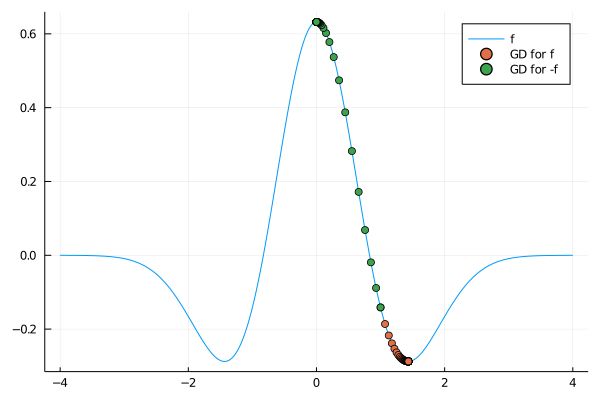

In [36]:
plot(xs, f; label="f")
scatter!(x_all1[:], f; label="GD for f")
scatter!(x_all3[:], f; label="GD for -f")

Když ale vykreslíme stejný graf pro Newtonovu metodu, vidíme, že v obou prípadech dokonvergoval ke stejnému bodu. Kdybychom vypsali iteraci, zjistili bychom, že jsou identické. Důvod je ten, že Newtonova metoda nerozlišuje mezi minimalizací a maximalizací (to odpovída přechodu od $f$ k $f_{\rm neg}$). Naopak, gradient descent mezi minimalizací a maximalizací rozlišuje a proto konverguje k jiným výsledkům.

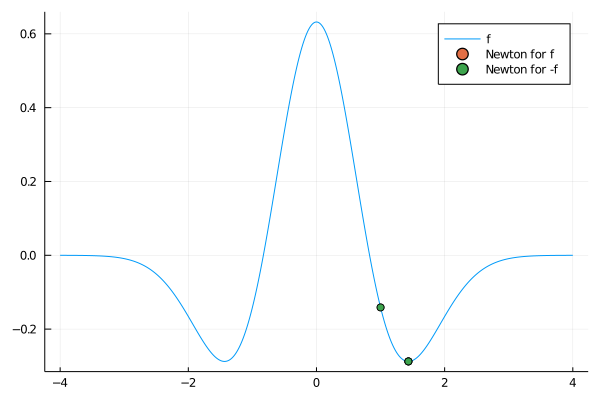

In [37]:
plot(xs, f; label="f")
scatter!(x_all2[:], f; label="Newton for f")
scatter!(x_all4[:], f; label="Newton for -f")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*